In [2]:
#Paso 1: Configuración del Entorno de Trabajo
# Instalar las librerías necesarias en Google Colab
!pip install pandas numpy matplotlib seaborn scikit-learn

In [3]:
#Paso 1: Configuración del Entorno de Trabajo
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:

# Cargar el archivo CSV en el cuaderno
df= pd.read_csv('ticker.csv', sep=';')

In [5]:

# Convertir la columna 'Close' a formato numérico (remover comas y convertir a float)
df['Close'] = df['Close'].str.replace(',', '.').astype(float)

In [6]:
# Convertir la columna 'Data' a formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d/%m/%Y')

In [7]:
# Mostrar las primeras filas para verificar
print(df.head())

  Ticker       Data     Close
0      A 2024-01-02  138.5250
1      A 2024-01-03  130.9473
2      A 2024-01-04  130.7875
3      A 2024-01-05  130.3482
4      A 2024-01-08  133.1637


In [8]:
#Paso 3: Cálculo de Retornos Porcentuales Diarios
# Calcular los retornos porcentuales diarios
df['Return'] = df.groupby('Ticker')['Close'].pct_change()

# Verificar si hay valores nulos generados en los retornos y manejarlos si es necesario
df['Return'].fillna(0, inplace=True)

In [10]:
#Paso 4: Cálculo de Indicadores de Volatilidad
# Calcular métricas de volatilidad: desviación estándar, rango, y media absoluta de los retornos diarios
volatility_df = df.groupby('Ticker')['Return'].agg([
    ('std_dev', 'std'),  # Desviación estándar
    ('range', lambda x: x.max() - x.min()),  # Rango
    ('mean_abs_dev', lambda x: np.mean(np.abs(x - x.mean())))  # Media absoluta de desviación personalizada
]).reset_index()

# Mostrar el DataFrame con las métricas de volatilidad
print(volatility_df.head())

  Ticker   std_dev     range  mean_abs_dev
0      A  0.015611  0.088351      0.011908
1    AAL  0.028820  0.197241      0.018525
2    AAP  0.021162  0.114642      0.016768
3   AAPL  0.012479  0.073428      0.009380
4   ABBV  0.008551  0.038986      0.006821


In [11]:
#Paso 5: Escalamiento de los Datos
# Escalar las métricas de volatilidad usando estandarización
scaler = StandardScaler()
volatility_scaled = scaler.fit_transform(volatility_df[['std_dev', 'range', 'mean_abs_dev']])

# Convertir de nuevo a un DataFrame para mejor visualización
volatility_scaled_df = pd.DataFrame(volatility_scaled, columns=['std_dev', 'range', 'mean_abs_dev'])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

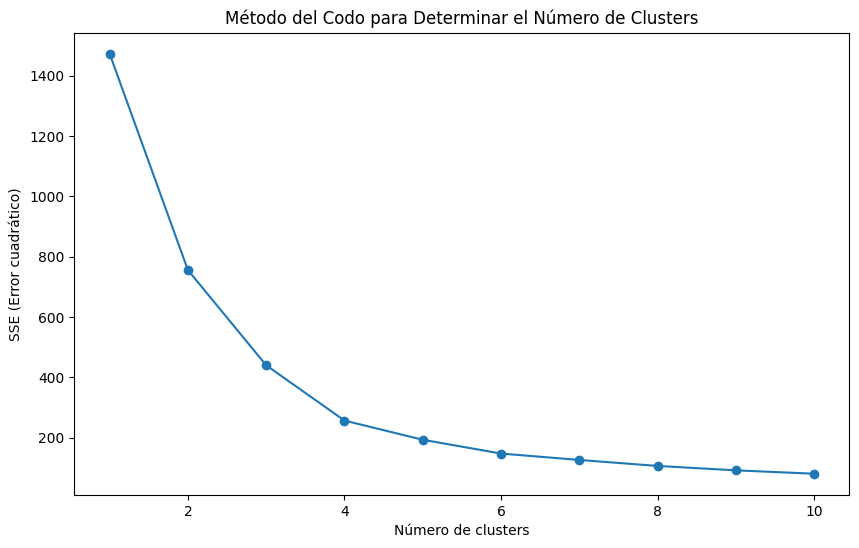

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
#Paso 6: Clusterización
# Determinar el número óptimo de clusters usando el método del codo
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(volatility_scaled_df)
    sse.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('SSE (Error cuadrático)')
plt.title('Método del Codo para Determinar el Número de Clusters')
plt.show()

# Aplicar el algoritmo K-means con el número óptimo de clusters (por ejemplo, 3)
kmeans = KMeans(n_clusters=3, random_state=42)
volatility_df['Cluster'] = kmeans.fit_predict(volatility_scaled_df)

In [13]:
#Paso 7: Reducción de Dimensionalidad para Visualización
# Reducir dimensionalidad con PCA para visualización en 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(volatility_scaled_df)
volatility_df['PCA1'] = pca_result[:, 0]
volatility_df['PCA2'] = pca_result[:, 1]

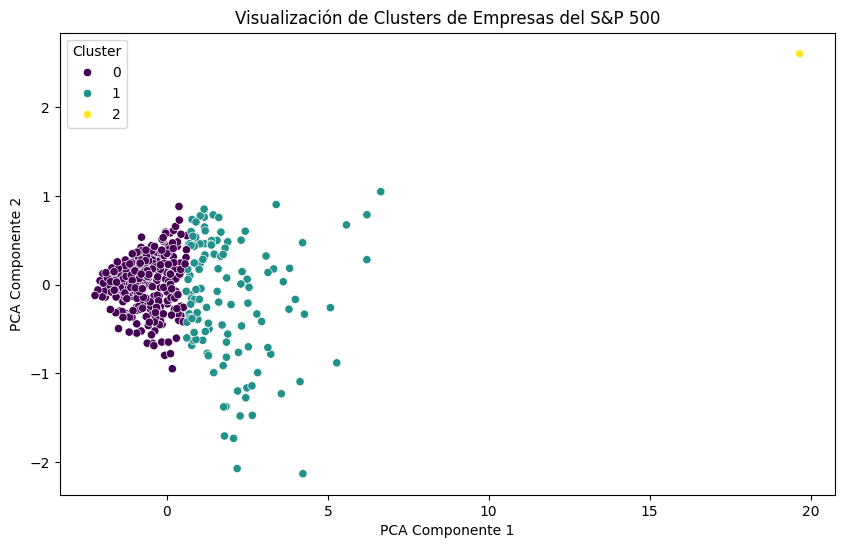

In [14]:
#Paso 8: Visualización de los Resultados
# Visualizar los clusters en un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=volatility_df, palette='viridis')
plt.title('Visualización de Clusters de Empresas del S&P 500')
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.show()

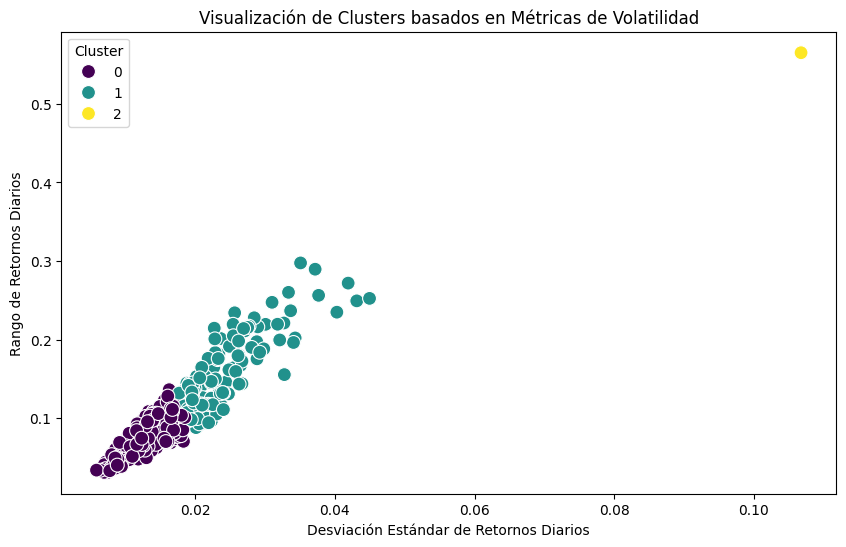


Interpretación de Resultados:
Cluster 0: Empresas con baja volatilidad - Precios de acciones relativamente estables.
Cluster 1: Empresas con volatilidad moderada - Fluctuaciones controladas en los retornos diarios.
Cluster 2: Empresas con alta volatilidad - Precios de acciones muy sensibles a cambios del mercado.

Patrones Observados:
1. Las empresas en Cluster 0 suelen ser grandes y consolidadas, con menor sensibilidad a cambios del mercado.
2. Las empresas en Cluster 1 pueden estar en sectores con fluctuaciones moderadas o en condiciones de mercado estables.
3. Las empresas en Cluster 2 tienden a ser más especulativas o en sectores altamente volátiles (ej: tecnología, startups).

Conclusiones:
El análisis de clusterización ha permitido clasificar las empresas del S&P 500 según su perfil de riesgo y volatilidad.
Esto proporciona una herramienta útil para la diversificación de portafolios, al identificar acciones de bajo riesgo para estabilidad y de alto riesgo para potenciales altos 

In [16]:
#Paso 9: Análisis e Interpretación
# Interpretar los resultados de los clusters
# Visualización de las empresas agrupadas por clusters para identificar patrones
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un gráfico de dispersión para visualizar los clusters usando las dos primeras métricas de volatilidad
plt.figure(figsize=(10, 6))
sns.scatterplot(x='std_dev', y='range', hue='Cluster', data=volatility_df, palette='viridis', s=100)
plt.title('Visualización de Clusters basados en Métricas de Volatilidad')
plt.xlabel('Desviación Estándar de Retornos Diarios')
plt.ylabel('Rango de Retornos Diarios')
plt.legend(title='Cluster')
plt.show()

# Análisis de los clusters y características de cada grupo
print("\nInterpretación de Resultados:")
print("Cluster 0: Empresas con baja volatilidad - Precios de acciones relativamente estables.")
print("Cluster 1: Empresas con volatilidad moderada - Fluctuaciones controladas en los retornos diarios.")
print("Cluster 2: Empresas con alta volatilidad - Precios de acciones muy sensibles a cambios del mercado.")

print("\nPatrones Observados:")
print("1. Las empresas en Cluster 0 suelen ser grandes y consolidadas, con menor sensibilidad a cambios del mercado.")
print("2. Las empresas en Cluster 1 pueden estar en sectores con fluctuaciones moderadas o en condiciones de mercado estables.")
print("3. Las empresas en Cluster 2 tienden a ser más especulativas o en sectores altamente volátiles (ej: tecnología, startups).")

# Conclusiones del análisis de clusterización
print("\nConclusiones:")
print("El análisis de clusterización ha permitido clasificar las empresas del S&P 500 según su perfil de riesgo y volatilidad.")
print("Esto proporciona una herramienta útil para la diversificación de portafolios, al identificar acciones de bajo riesgo para estabilidad y de alto riesgo para potenciales altos retornos.")
print("Además, facilita el monitoreo de sectores específicos del mercado y puede ayudar a detectar cambios significativos en su comportamiento.")